In [1]:
# ------------------------------------------------------------------
# 0. IMPORTS Y CONFIGURACIÓN GLOBAL
# ------------------------------------------------------------------
import os, glob, cv2, numpy as np, tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add,
    GlobalAveragePooling1D, Bidirectional, LSTM
)
from tensorflow.keras import Model
from pathlib import Path

from utils.extraction import *

2025-05-12 21:34:41.665291: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747103681.698190  441167 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747103681.705201  441167 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747103681.730143  441167 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747103681.730183  441167 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747103681.730186  441167 computation_placer.cc:177] computation placer alr

In [2]:
# ----------------------- HIPERPARÁMETROS --------------------------
MODEL_TYPE       = "transformer"     # "transformer"  o  "lstm"
LABEL_SMOOTH     = 0.05
D_MODEL          = 512
NUM_HEADS        = 8
FF_DIM           = 1024
NUM_LAYERS       = 4
LSTM_UNITS       = 256
DROPOUT          = 0.3
EPOCHS           = 40
STEPS_PER_EPOCH  = 250
VAL_STEPS        = 60

In [ ]:
# ------------------------------------------------------------------
# 1. DATASETS
# ------------------------------------------------------------------
train_ds = make_dataset("train", shuffle=True)
val_ds   = make_dataset("validation", shuffle=False)

# ------------------------------------------------------------------
# 2. BLOQUES TEMPORALES
# ------------------------------------------------------------------
def transformer_block(x):
    for _ in range(NUM_LAYERS):
        attn = MultiHeadAttention(NUM_HEADS, key_dim=D_MODEL // NUM_HEADS)(x, x)
        x    = LayerNormalization()(x + Dropout(DROPOUT)(attn))
        ffn  = Dense(FF_DIM, activation="gelu")(x)
        ffn  = Dense(D_MODEL)(ffn)
        x    = LayerNormalization()(x + Dropout(DROPOUT)(ffn))
    return GlobalAveragePooling1D()(x)           # (batch, D_MODEL)

def lstm_block(x):
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Dropout(DROPOUT)(x)
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=False))(x)
    return x                                      # (batch, 2*LSTM_UNITS)

def build_model() -> Model:
    inp = Input(shape=(NUM_FRAMES, 1280))

    if MODEL_TYPE == "transformer":
        # proyección + embedding posicional
        pos = tf.range(NUM_FRAMES)
        pos_emb = tf.keras.layers.Embedding(NUM_FRAMES, D_MODEL)(pos)
        x = Dense(D_MODEL)(inp) + pos_emb
        x = transformer_block(x)
    else:  # "lstm"
        x = LayerNormalization()(inp)
        x = lstm_block(x)

    x = Dropout(DROPOUT)(x)
    x = Dense(256, activation="gelu")(x)
    out = Dense(DEPTH, activation="softmax")(x)
    return Model(inp, out, name=f"engage_{MODEL_TYPE}")

model = build_model()
model.summary(line_length=120)

# ------------------------------------------------------------------
# 3. COMPILACIÓN
# ------------------------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.AdamW(1e-4, weight_decay=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(
        from_logits=False, label_smoothing=LABEL_SMOOTH),
    metrics=["accuracy"],
)

# ------------------------------------------------------------------
# 4. CALLBACKS Y ENTRENAMIENTO
# ------------------------------------------------------------------
ckpt_dir = Path(f"checkpoints_{MODEL_TYPE}"); ckpt_dir.mkdir(exist_ok=True)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(ckpt_dir / "best.weights.h5"),
        monitor="val_accuracy", mode="max",
        save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=20, restore_best_weights=True),
]

history = model.fit(
    train_ds,
    epochs            =EPOCHS,
    steps_per_epoch   =STEPS_PER_EPOCH,
    validation_data   =val_ds,
    validation_steps  =VAL_STEPS,
    callbacks         =callbacks,
)

I0000 00:00:1747103685.698858  441167 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4080 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "engage_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)          │ (None, 32, 1280)             │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense (Dense)                     │ (None, 32, 512)              │           655,872 │ input_layer[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ add (Add)                         │ (None, 32, 512)              │                 0 │ dense[0][0]               
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ multi_head_attention              │ (None, 32, 512)              │         1,050,624 │ add[0][0], add[0][0]      
│ (MultiHeadAttention)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dropout_1 (Dropout)               │ (None, 32, 512)              │                 0 │ multi_head_attention[0][0]
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ add_1 (Add)                       │ (None, 32, 512)              │                 0 │ add[0][0], dropout_1[0][0]
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ layer_normalization               │ (None, 32, 512)              │             1,024 │ add_1[0][0]               
│ (LayerNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_1 (Dense)                   │ (None, 32, 1024)             │           525,312 │ layer_normalization[0][0] 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_2 (Dense)                   │ (None, 32, 512)              │           524,800 │ dense_1[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dropout_2 (Dropout)               │ (None, 32, 512)              │                 0 │ dense_2[0][0]             
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ add_2 (Add)                       │ (None, 32, 512)              │                 0 │ layer_normalization[0][0],
│                                   │                              │                   │ dropout_2[0][0]           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ layer_normalization_1             │ (None, 32, 512)              │             1,024 │ add_2[0][0]               
│ (LayerNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ multi_head_attention_1            │ (None, 32, 512)              │         1,050,624 │ layer_normalization_1[0][0
│ (MultiHeadAttention)              │                              │                   │ layer_normalization_1[0][0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dropout_4 (Dropout)               │ (None, 32, 512)   

 Total params: 9,199,364 (35.09 MB)

 Trainable params: 9,199,364 (35.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40


I0000 00:00:1747103703.186062  441257 service.cc:152] XLA service 0x7f5db00158f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747103703.186113  441257 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2025-05-12 21:35:03.530894: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747103705.239517  441257 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747103716.066534  441257 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.5879 - loss: 0.9842 - val_accuracy: 0.3135 - val_loss: 1.7314
Epoch 2/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.6740 - loss: 0.7831 - val_accuracy: 0.3604 - val_loss: 1.7669
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.6966 - loss: 0.7372 - val_accuracy: 0.3391 - val_loss: 1.7212
Epoch 4/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.7241 - loss: 0.7013 - val_accuracy: 0.3688 - val_loss: 1.6211
Epoch 5/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 51ms/step - accuracy: 0.7320 - loss: 0.6757 - val_accuracy: 0.3745 - val_loss: 1.8202
Epoch 6/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.7426 - loss: 0.6569 - val_accuracy: 0.3594 - val_loss: 1.7595
Epoch 7/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.7468 - loss: 0.6503 - val_accuracy: 0.3495 - val_loss: 1.8622
Epoch 8/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.7730 - loss: 0.6146 - val_accurac

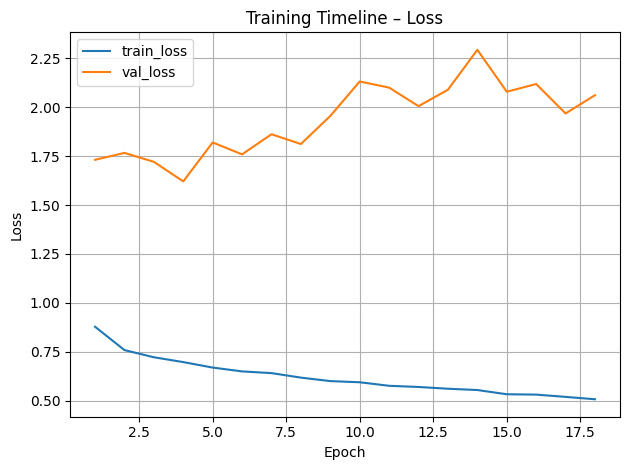

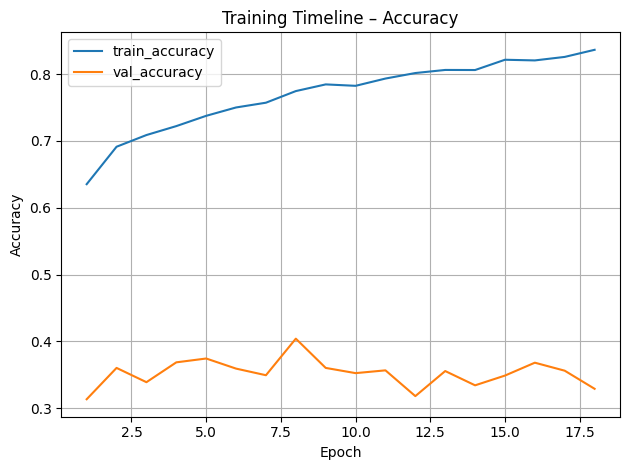

In [4]:
import matplotlib.pyplot as plt

def plot_metric(metric_name, title):
    train_values = history.history[metric_name]
    val_key      = "val_" + metric_name
    val_values   = history.history.get(val_key)

    epochs = range(1, len(train_values) + 1)

    plt.figure()                             # 1 plot por figura (sin subplots)
    plt.plot(epochs, train_values, label=f"train_{metric_name}")
    if val_values is not None:
        plt.plot(epochs, val_values, label=f"val_{metric_name}")
    plt.xlabel("Epoch")
    plt.ylabel(metric_name.capitalize())
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Traza loss y accuracy (ajusta si usas otras métricas)
plot_metric("loss",      "Training Timeline – Loss")
plot_metric("accuracy",  "Training Timeline – Accuracy")

In [5]:
# ------------------------------------------------------------------
# 5.  EVALUACIÓN FINAL EN TEST
# ------------------------------------------------------------------
import math, glob
from sklearn.metrics import confusion_matrix, classification_report

# a) dataset de test (mismo formato: one-hot)  ──────────────────────
test_ds = make_dataset("test", shuffle=False)

# b) nº de muestras reales para limitar los steps
test_files = []
for cls in CLASSES:
    test_files += glob.glob(os.path.join(OUTPUT_FEATURES, cls, "test", "*.npy"))
N_TEST      = len(test_files)
TEST_STEPS  = math.ceil(N_TEST / BATCH_SIZE)

print(f"\nEvaluando en test ({N_TEST} vídeos)…")
test_loss, test_acc = model.evaluate(test_ds, steps=TEST_STEPS, verbose=1)
print(f"Loss={test_loss:.4f}  |  Accuracy={test_acc:.4f}")


Evaluando en test (527 vídeos)…
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.4420 - loss: 1.6163
Loss=1.5659  |  Accuracy=0.4375


In [ ]:
# ------------------------------------------------------------------
# 6.  MATRIZ DE CONFUSIÓN
# ------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

y_true, y_pred = [], []

for xb, yb in test_ds.take(TEST_STEPS):
    preds = model.predict(xb, verbose=0)
    y_true.append(tf.argmax(yb, axis=1).numpy())       # (batch,)
    y_pred.append(tf.argmax(preds, axis=1).numpy())    # (batch,)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=range(DEPTH))

# Visualizar la matriz
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, 
            yticklabels=CLASSES)

# Mejorar la visualización
plt.xlabel('Predicción', fontsize=14)
plt.ylabel('Verdad', fontsize=14)
plt.title('Matriz de Confusión', fontsize=16)

# Personalizar los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Calcular precisión por clase para el título
class_acc = np.diag(cm) / np.sum(cm, axis=1)
acc_str = f"Accuracy: {test_acc:.2f} | UAR: {np.mean(class_acc):.2f}"
plt.figtext(0.5, 0.01, acc_str, ha="center", fontsize=14)

plt.tight_layout()
plt.show()

# También mostrar la matriz numérica para referencia
print("\nMatriz de confusión (filas=verdad, columnas=predicción):")
print(cm)

In [7]:

# ------------------------------------------------------------------
# 7.  REPORTE DE MÉTRICAS P,R,F1
# ------------------------------------------------------------------
print("\nReporte clasificación:")
target_names = [f"Clase {c}" for c in CLASSES]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))



Reporte clasificación:
              precision    recall  f1-score   support

     Clase 0     0.8125    0.2393    0.3697       163
     Clase 1     0.4912    0.2171    0.3011       129
     Clase 2     0.3112    0.5041    0.3849       121
     Clase 3     0.3086    0.5725    0.4011       131

    accuracy                         0.3732       544
   macro avg     0.4809    0.3832    0.3642       544
weighted avg     0.5035    0.3732    0.3643       544



In [8]:
# -----------------------------------------------------------------
# 8. MÉTRICA UAR (Unweighted Average Recall)
# -----------------------------------------------------------------
from sklearn.metrics import confusion_matrix

def uar_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASSES))))
    recalls = np.diag(cm) / np.maximum(cm.sum(axis=1), 1)   # evita división por 0
    return recalls.mean()

uar = uar_score(y_true, y_pred)
print(f"\nUAR (macro-recall sin ponderar): {uar:.4f}")


UAR (macro-recall sin ponderar): 0.3832
